In [1]:
!pip install -U sentence-transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, IterableDataset
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [4]:
# os.chdir('..')
os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [5]:
from fashion_recommendations.metrics.average_precision import mapk

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
class RecommendationDatasetMultiLabel(IterableDataset):

    def __init__(self, dataset_filepath, article_emb_bag, total_articles):
        
        self.dataset_itr = open(dataset_filepath, 'r')
        next(self.dataset_itr)  # skip header
        
        self.article_emb_bag = article_emb_bag
        
        self.total_articles = total_articles
    
    def process_label(self, label_str: str, num_purchases_str: str):
        
        labels = torch.tensor([int(v) for v in label_str.split(',')])
        
        num_purchases = torch.tensor([float(v) for v in num_purchases_str.split(',')])
        
        target = torch.zeros(self.total_articles).scatter_(0, labels, num_purchases)
        
        target = target / target.sum()  # Normalise

        return target
    
    def mean_historical_purchases_embedding(self, input_str: str):
        
        indices = torch.tensor([int(v) for v in input_str.split(',')])

        mean_emb = self.article_emb_bag(indices.unsqueeze(0)).flatten()
            
        return mean_emb
    
    def process_numeric_features(self, fn: str, active: str, age: str, example_age: str):
        numeric_features_tensor = torch.tensor([
            float(fn),
            float(active),
            float(age),
            float(example_age)
        ])

        return numeric_features_tensor
    
    def parse_itr(self, dataset_itr):
        
        for line in dataset_itr:
        
            line_items = line.rstrip('\n').split('\t')
            
            customer_id_idx, article_id_idx_last10, article_id_idx_label, fn, active, age, num_purchases, example_age = line_items
            
            customer_id_idx = int(customer_id_idx)
            
            numeric_features_tensor = self.process_numeric_features(fn, active, age, example_age)
            
            mean_emb = self.mean_historical_purchases_embedding(article_id_idx_last10)

            label = self.process_label(article_id_idx_label, num_purchases)    
            
            inputs = torch.concat((mean_emb, numeric_features_tensor))

            yield customer_id_idx, inputs, label
        
    def get_stream(self, dataset_itr):
        
        return self.parse_itr(dataset_itr)

    def __iter__(self):
        
        return self.get_stream(self.dataset_itr)

In [8]:
articles_df = pd.read_csv('data/articles_df_filt_with_counts_and_age.csv', dtype={'article_id': str})
print(articles_df.shape)
articles_df.head()

(40538, 3)


,article_id,detail_desc,article_id_idx
0,0108775015,Jersey top with narrow shoulder straps.,0
1,0108775044,Jersey top with narrow shoulder straps.,1
2,0110065001,"Microfibre T-shirt bra with underwired, moulde...",2
3,0110065002,"Microfibre T-shirt bra with underwired, moulde...",3
4,0110065011,"Microfibre T-shirt bra with underwired, moulde...",4


In [9]:
customers = pd.read_csv('data/customers_filt_with_counts_and_age.csv')
print(customers.shape)
customers.head()

(43108, 5)


,customer_id,FN,Active,age,customer_id_idx
0,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,0.0,0.0,0.45,0
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,1.0,1.0,0.44,1
2,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,0.0,0.0,0.21,2
3,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,1.0,1.0,0.33,3
4,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,0.0,0.0,0.21,4


### Create article EmbeddingBag

In [10]:
model = SentenceTransformer('all-distilroberta-v1')

In [11]:
article_descriptions = articles_df['detail_desc'].to_list()
article_descriptions[:5]

['Jersey top with narrow shoulder straps.',
 'Jersey top with narrow shoulder straps.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.']

In [12]:
model.encode(article_descriptions[0]).shape

(768,)

In [13]:
embeddings = model.encode(article_descriptions)

In [14]:
embeddings = torch.tensor(embeddings)

In [15]:
embeddings.shape

torch.Size([40538, 768])

In [16]:
ARTICLE_EMBEDDING_BAG = nn.EmbeddingBag.from_pretrained(embeddings=embeddings, freeze=True)

### Model

In [17]:
class FashionRecV3(nn.Module):

    def __init__(self, user_embedding_dim):
        super(FashionRecV3, self).__init__()
        
        # Embeddings
        self.user_embeddings = nn.Embedding(num_embeddings=len(customers), embedding_dim=user_embedding_dim)        
        
        # Initialise embeddings
        torch.nn.init.xavier_uniform_(self.user_embeddings.weight)
        
        # FC layers
        self.fc_1 = nn.Linear(in_features=user_embedding_dim+768+4, out_features=2048)            
        self.fc_2 = nn.Linear(in_features=2048, out_features=1024)
        # self.fc_3 = nn.Linear(in_features=1024, out_features=512)
        self.fc_3 = nn.Linear(in_features=1024, out_features=len(articles_df))
        
        # Activation functions
        self.relu = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(0.01)
        
    def forward(
        self, 
        customer_id_idx, 
        inputs
    ):

        user_emb = self.user_embeddings(customer_id_idx)
              
        concatenated_features = torch.concat(
            [
                user_emb, 
                inputs
            ], 
            dim=1
        )
        
        x = self.fc_1(concatenated_features)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc_3(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        
        # x = self.fc_4(x)

        return x

In [18]:
fashion_rec_v3 = FashionRecV3(user_embedding_dim=384)

In [19]:
fashion_rec_v3.to(device)

FashionRecV3(
  (user_embeddings): Embedding(43108, 384)
  (fc_1): Linear(in_features=1156, out_features=2048, bias=True)
  (fc_2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc_3): Linear(in_features=1024, out_features=40538, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.01, inplace=False)
)

In [20]:
BATCH_SIZE = 1024

In [21]:
total_training_examples = pd.read_csv('data/final_train_set_with_counts_and_age.tsv', sep='\t').shape[0]
total_batches = np.ceil(total_training_examples/BATCH_SIZE)
total_batches

43.0

In [22]:
total_dev_examples = pd.read_csv('data/final_dev_set_with_counts_and_age.tsv', sep='\t').shape[0]
total_dev_batches = np.ceil(total_dev_examples/BATCH_SIZE)
total_dev_batches

9.0

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=fashion_rec_v3.parameters(), lr=0.001)

In [232]:
MAX_EPOCHS = 25

# training_losses = []
# dev_losses = []

for epoch in range(MAX_EPOCHS):
    
    # Since we use an IterableDataset we need to reinstaniate the dataset since file end will have been reached:
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set_with_counts_and_age.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    for data in tqdm(train_loader, total=total_batches):
        
        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        loss = criterion(y_pred, label)

        loss.backward()    
        
        optimizer.step()
    
    # Compute train loss:
    
    total_train_loss = 0

    fashion_rec_v3.eval()
    
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set_with_counts_and_age.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    with torch.no_grad():
        for data in tqdm(train_loader, total=total_batches):

            customer_id_idx, inputs, label = data
            customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

            optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            y_pred = fashion_rec_v3(customer_id_idx, inputs)

            loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, label)

            total_train_loss += loss.item()

        mean_train_loss = total_train_loss / total_training_examples
        print(f"Training loss: {mean_train_loss}")
        training_losses.append(mean_train_loss)
        
    # Compute dev loss:
    
    total_dev_loss = 0
    
    dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_dev_set_with_counts_and_age.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  
    
    with torch.no_grad():
        for data in tqdm(dev_loader, total=total_dev_batches):

            customer_id_idx, inputs, label = data
            customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

            y_pred = fashion_rec_v3(customer_id_idx, inputs)

            loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, label)

            total_dev_loss += loss.item()

        mean_dev_loss = total_train_loss / total_dev_examples
        print(f"Dev loss: {mean_dev_loss}")
        dev_losses.append(mean_dev_loss)
        
    fashion_rec_v3.train()

100%|██████████| 43/43.0 [00:15<00:00,  2.72it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.60it/s]


Training loss: 0.8773024855379471


100%|██████████| 9/9.0 [00:03<00:00,  2.61it/s]


Dev loss: 4.146793371334411


100%|██████████| 43/43.0 [00:15<00:00,  2.71it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.64it/s]


Training loss: 0.8848911305576482


100%|██████████| 9/9.0 [00:03<00:00,  2.63it/s]


Dev loss: 4.182663032464814


100%|██████████| 43/43.0 [00:15<00:00,  2.75it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.67it/s]


Training loss: 0.8870300189610524


100%|██████████| 9/9.0 [00:03<00:00,  2.62it/s]


Dev loss: 4.192773032606694


100%|██████████| 43/43.0 [00:15<00:00,  2.74it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.65it/s]


Training loss: 0.8866744656017255


100%|██████████| 9/9.0 [00:03<00:00,  2.49it/s]


Dev loss: 4.191092419206051


100%|██████████| 43/43.0 [00:15<00:00,  2.74it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.67it/s]


Training loss: 0.88709252573314


100%|██████████| 9/9.0 [00:03<00:00,  2.61it/s]


Dev loss: 4.193068486765811


100%|██████████| 43/43.0 [00:15<00:00,  2.70it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.67it/s]


Training loss: 0.8841781166673448


100%|██████████| 9/9.0 [00:03<00:00,  2.51it/s]


Dev loss: 4.179292790931568


100%|██████████| 43/43.0 [00:15<00:00,  2.74it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.67it/s]


Training loss: 0.8887867031573498


100%|██████████| 9/9.0 [00:03<00:00,  2.63it/s]


Dev loss: 4.201076447336297


100%|██████████| 43/43.0 [00:15<00:00,  2.74it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.68it/s]


Training loss: 0.8870875910857817


100%|██████████| 9/9.0 [00:03<00:00,  2.60it/s]


Dev loss: 4.193045161899767


100%|██████████| 43/43.0 [00:15<00:00,  2.75it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.67it/s]


Training loss: 0.8888995160062757


100%|██████████| 9/9.0 [00:03<00:00,  2.57it/s]


Dev loss: 4.201609685964752


100%|██████████| 43/43.0 [00:16<00:00,  2.69it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.65it/s]


Training loss: 0.8876080027623887


100%|██████████| 9/9.0 [00:03<00:00,  2.61it/s]


Dev loss: 4.195505020074677


100%|██████████| 43/43.0 [00:15<00:00,  2.72it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.67it/s]


Training loss: 0.8879286663490444


100%|██████████| 9/9.0 [00:03<00:00,  2.67it/s]


Dev loss: 4.1970207180893215


100%|██████████| 43/43.0 [00:15<00:00,  2.74it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.63it/s]


Training loss: 0.8880458664360942


100%|██████████| 9/9.0 [00:03<00:00,  2.61it/s]


Dev loss: 4.197574694114819


100%|██████████| 43/43.0 [00:15<00:00,  2.74it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.62it/s]


Training loss: 0.8877326333147814


100%|██████████| 9/9.0 [00:03<00:00,  2.61it/s]


Dev loss: 4.196094118084824


100%|██████████| 43/43.0 [00:15<00:00,  2.71it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.67it/s]


Training loss: 0.8871148912851561


100%|██████████| 9/9.0 [00:03<00:00,  2.64it/s]


Dev loss: 4.1931742032368975


100%|██████████| 43/43.0 [00:15<00:00,  2.75it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.68it/s]


Training loss: 0.8856467253823133


100%|██████████| 9/9.0 [00:03<00:00,  2.67it/s]


Dev loss: 4.186234543616312


100%|██████████| 43/43.0 [00:15<00:00,  2.73it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.63it/s]


Training loss: 0.8852776919157239


100%|██████████| 9/9.0 [00:03<00:00,  2.60it/s]


Dev loss: 4.184490213059543


100%|██████████| 43/43.0 [00:15<00:00,  2.72it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.63it/s]


Training loss: 0.883890560631895


100%|██████████| 9/9.0 [00:03<00:00,  2.65it/s]


Dev loss: 4.177933584179795


100%|██████████| 43/43.0 [00:15<00:00,  2.76it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.66it/s]


Training loss: 0.8851154441015834


100%|██████████| 9/9.0 [00:03<00:00,  2.64it/s]


Dev loss: 4.18372330749244


100%|██████████| 43/43.0 [00:15<00:00,  2.71it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.63it/s]


Training loss: 0.8864048372629546


100%|██████████| 9/9.0 [00:03<00:00,  2.64it/s]


Dev loss: 4.189817952273184


100%|██████████| 43/43.0 [00:15<00:00,  2.72it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.67it/s]


Training loss: 0.8844522393191139


100%|██████████| 9/9.0 [00:03<00:00,  2.63it/s]


Dev loss: 4.18058850137811


100%|██████████| 43/43.0 [00:16<00:00,  2.69it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.66it/s]


Training loss: 0.884646476327217


100%|██████████| 9/9.0 [00:03<00:00,  2.61it/s]


Dev loss: 4.181506612008078


100%|██████████| 43/43.0 [00:15<00:00,  2.74it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.65it/s]


Training loss: 0.8837372196774829


100%|██████████| 9/9.0 [00:03<00:00,  2.64it/s]


Dev loss: 4.1772087791509795


100%|██████████| 43/43.0 [00:15<00:00,  2.70it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.65it/s]


Training loss: 0.885150558289033


100%|██████████| 9/9.0 [00:03<00:00,  2.60it/s]


Dev loss: 4.183889283631977


100%|██████████| 43/43.0 [00:16<00:00,  2.68it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.67it/s]


Training loss: 0.8835029421527852


100%|██████████| 9/9.0 [00:03<00:00,  2.58it/s]


Dev loss: 4.176101406833582


100%|██████████| 43/43.0 [00:15<00:00,  2.73it/s]
100%|██████████| 43/43.0 [00:16<00:00,  2.64it/s]


Training loss: 0.8815799458986799


100%|██████████| 9/9.0 [00:03<00:00,  2.60it/s]

Dev loss: 4.167011875855295


In [240]:
training_losses[-1], dev_losses[-1]

(0.8815799458986799, 4.167011875855295)

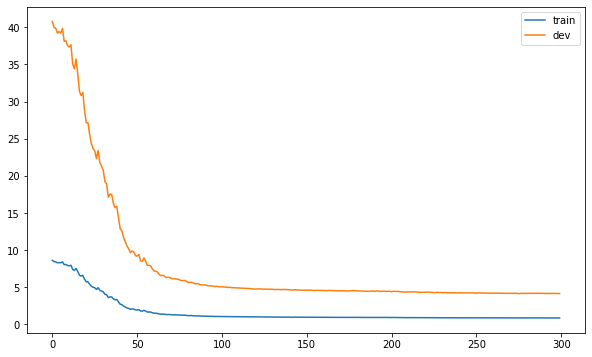

In [241]:
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.legend()
plt.show()

### MAP@12

#### Train

In [242]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set_with_counts_and_age.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(1000, dim=1).indices)

100%|██████████| 43/43.0 [00:15<00:00,  2.75it/s]


In [243]:
predictions = torch.concat(predictions)

In [244]:
predictions.shape

torch.Size([43108, 1000])

In [245]:
actuals = pd.read_csv('data/final_train_set_with_counts_and_age.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

43108

In [246]:
mapk(actuals, predictions.tolist(), 12)

0.9997996669077653

🤯

In [247]:
def precision(a: list, b: list):
    a = set(a)
    b = set(b)
    num_common = len(a.intersection(b))
    return num_common / len(a)

In [248]:
np.mean(
    [precision(act, pred) for act, pred in zip(actuals, predictions.tolist())]
)

1.0

In [249]:
number_of_positive_examples = [len(set(act).intersection(set(pred))) for act, pred in zip(actuals, predictions.tolist())]

In [250]:
np.mean(np.array(number_of_positive_examples ) > 0)

1.0

Model is a strong top-1000 candidate generator:
- 99+% precision
- Can use all customers in training set since each has at least 1 positive example 

This could then facilitate a 2-stage approach like YouTube

#### Dev

In [251]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_dev_set_with_counts_and_age.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_dev_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        # predictions.append(y_pred.topk(12, dim=1).indices)
        predictions.append(y_pred.topk(1000, dim=1).indices)

100%|██████████| 9/9.0 [00:03<00:00,  2.65it/s]


In [252]:
predictions = torch.concat(predictions)

In [253]:
predictions.shape

torch.Size([9120, 1000])

In [254]:
actuals = pd.read_csv('data/final_dev_set_with_counts_and_age.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

9120

In [255]:
mapk(actuals, predictions.tolist(), 12)

0.0612908650261683

In [256]:
def precision(a: list, b: list):
    a = set(a)
    b = set(b)
    num_common = len(a.intersection(b))
    return num_common / len(a)

In [257]:
np.mean(
    [precision(act, pred) for act, pred in zip(actuals, predictions.tolist())]
)

0.3192454923987504

In [258]:
number_of_positive_examples = [len(set(act).intersection(set(pred))) for act, pred in zip(actuals, predictions.tolist())]

In [259]:
np.mean(np.array(number_of_positive_examples) > 0)

0.5326754385964912

In a 2-step approach this is the metric we would care about most. 35% is similar to what was achieved with simple heuristic candidate generators but here we also acheive strong MAP!

In [260]:
actuals_perfect_order = [[i for i in act if i in pred] for act, pred in zip(actuals, predictions.tolist())]

In [261]:
mapk(actuals_perfect_order, predictions.tolist(), 12)

0.08313944000387975

Interesting! Maximum upside if we perfectly ordered the top-1000 articles is ~0.02

#### Test

In [262]:
total_test_batches = np.ceil(pd.read_csv('data/final_test_set_with_counts_and_age.tsv', sep='\t').shape[0]/BATCH_SIZE)

In [263]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_test_set_with_counts_and_age.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_test_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|██████████| 9/9.0 [00:03<00:00,  2.81it/s]


In [264]:
predictions = torch.concat(predictions)

In [265]:
predictions.shape

torch.Size([8733, 12])

In [266]:
actuals = pd.read_csv('data/final_test_set_with_counts_and_age.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

8733

In [267]:
mapk(actuals, predictions.tolist(), 12)

0.020076675695344284

In [268]:
# Number of unique items in predictions
len(predictions.unique())

10896

In [269]:
# Number of unique items in actuals
len(set([item for sublist in actuals for item in sublist]))

8318

- Adding example age and counts for labels doesn't seem to make a huge difference to model without these features
- Can train for more epochs to gain additional performance
- Consider lowering learning rate after 100/150 epochs